## CA2 AIML Unsuperivsed Learning
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
### Background Infomation
As the owner of a shopping mall, having data about your customers' age, gender, income, and spending provides valuable insights for understanding your customer base and making informed business decisions. Customer segmentation is a vital aspect of the bussiness of a shopping mall. By segmenting customers into distinct groups based on common characteristics, we can better understand the diverse needs and preferences of our clientele. This segmentation process can reveal valuable patterns, such as groups of customers with similar spending behaviors, age preferences, or income levels.
### Problem Statement
>Our objective is to apply clustering techniques to segment our customers, and identify the most valuable customers

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from warnings import filterwarnings 
from random import sample
from scipy.cluster.hierarchy import dendrogram, linkage
# Statistical Analysis
from scipy import stats

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import Pipeline
# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering ,DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram


# Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer

## Functions

### Importing Dataset

In [37]:
df = pd.read_csv('./datasets/Customer_Dataset.csv')
df

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


# Descriptive Anaylsis

In [38]:
df_eda = df.copy()

#### Checking For NULL Values

In [39]:
df_eda.isnull().sum()

CustomerID             0
Gender                 0
Age                    0
Income (k$)            0
How Much They Spend    0
dtype: int64

In [40]:
df_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
How Much They Spend,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [41]:
df_eda.info()
df_eda.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           200 non-null    int64 
 1   Gender               200 non-null    object
 2   Age                  200 non-null    int64 
 3   Income (k$)          200 non-null    int64 
 4   How Much They Spend  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


(200, 5)

__Observations:__
- There are no NULL values in this dataset
- The shape of the Dataset is 200 x 5 (which is relatively small)

In [42]:
df_eda.nunique()

CustomerID             200
Gender                   2
Age                     51
Income (k$)             64
How Much They Spend     84
dtype: int64

__Observations__
- Only the Gender Column is binary

# Exploratory Data Anaylsis
## Univariate

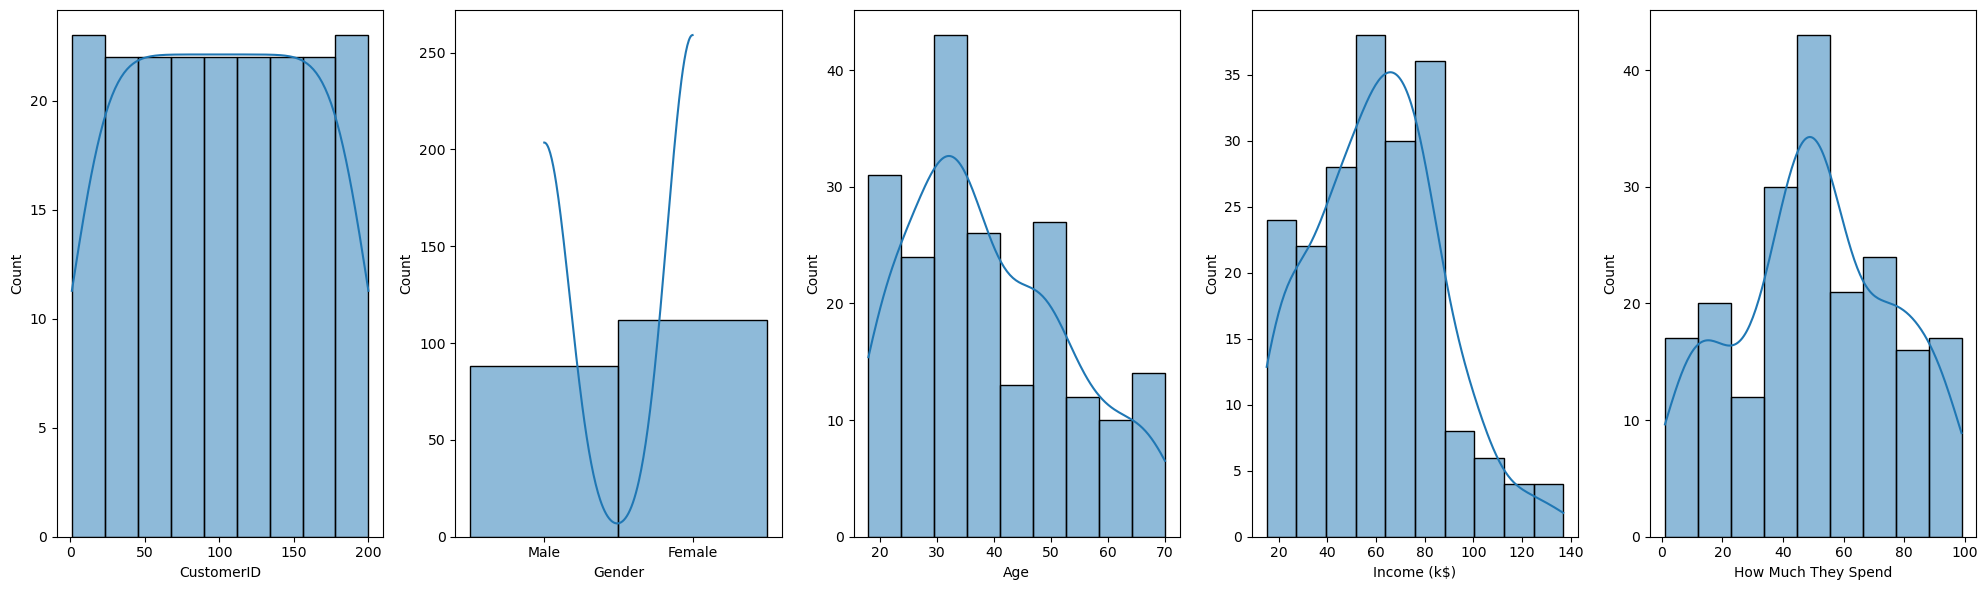

In [43]:
fig1, axes1 = plt.subplots(1, 5, figsize=(20, 6))

for var, ax in zip(df, axes1.flatten()):
    sns.histplot(df[var], ax=ax, bins='auto', alpha=.5, kde=True)

plt.tight_layout()
plt.show()

__Observations__
- Females has a slightly higher count than males
- `Customer ID` has a uniform distribution suggesting that each value is unique and we should discard it in our feature selection.
- Distribution of `Age` appears to be positively skewed , with most customers ranging from ages 20 to 50.
- Distribution of `Income` also appears to be positively skewed, wiht most incomes being in the range of 20k to 80k.
- `Amount of Customer exoenditure` has a relatively normal distribution with the mean being around 50

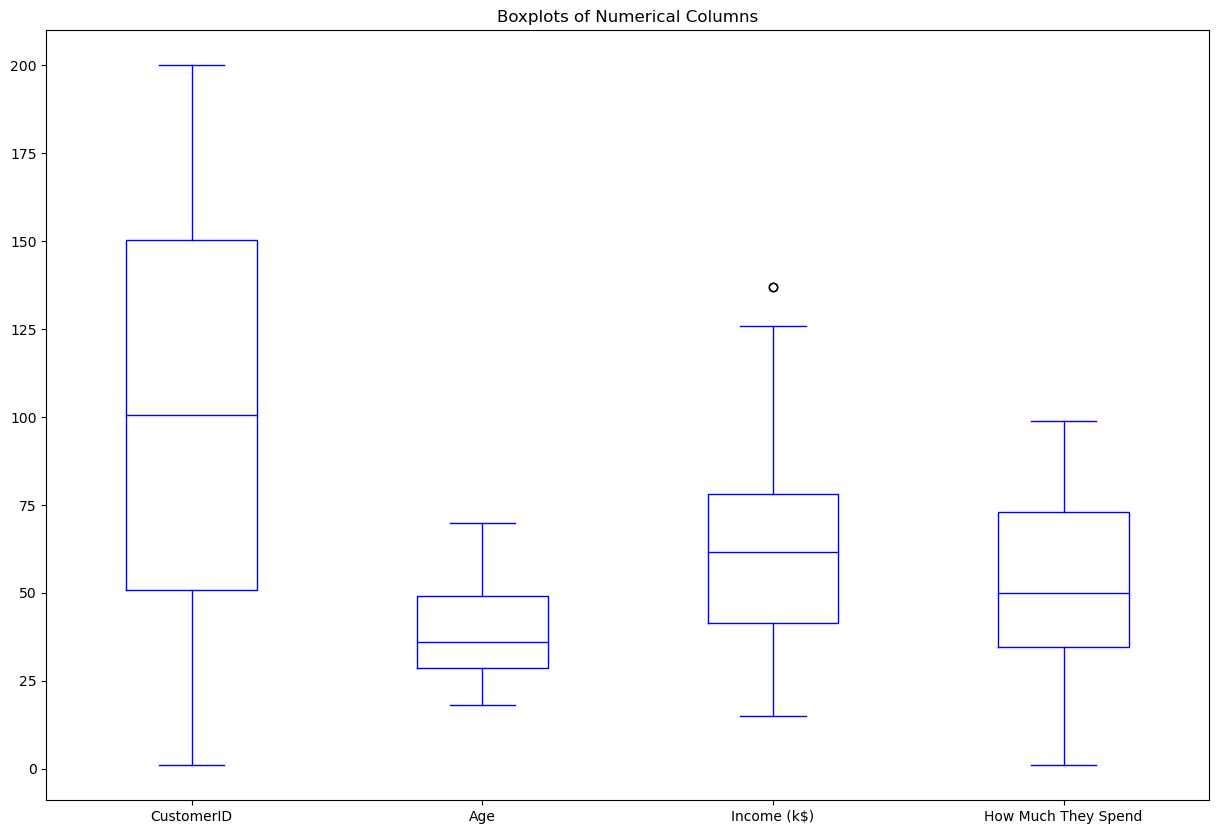

In [44]:
fig, ax = plt.subplots(figsize=(15, 10))
df.plot.box(ax=ax,color='blue')
plt.title("Boxplots of Numerical Columns")
plt.show()

__Observations__
- `Income` has a minor outlier at around 140k

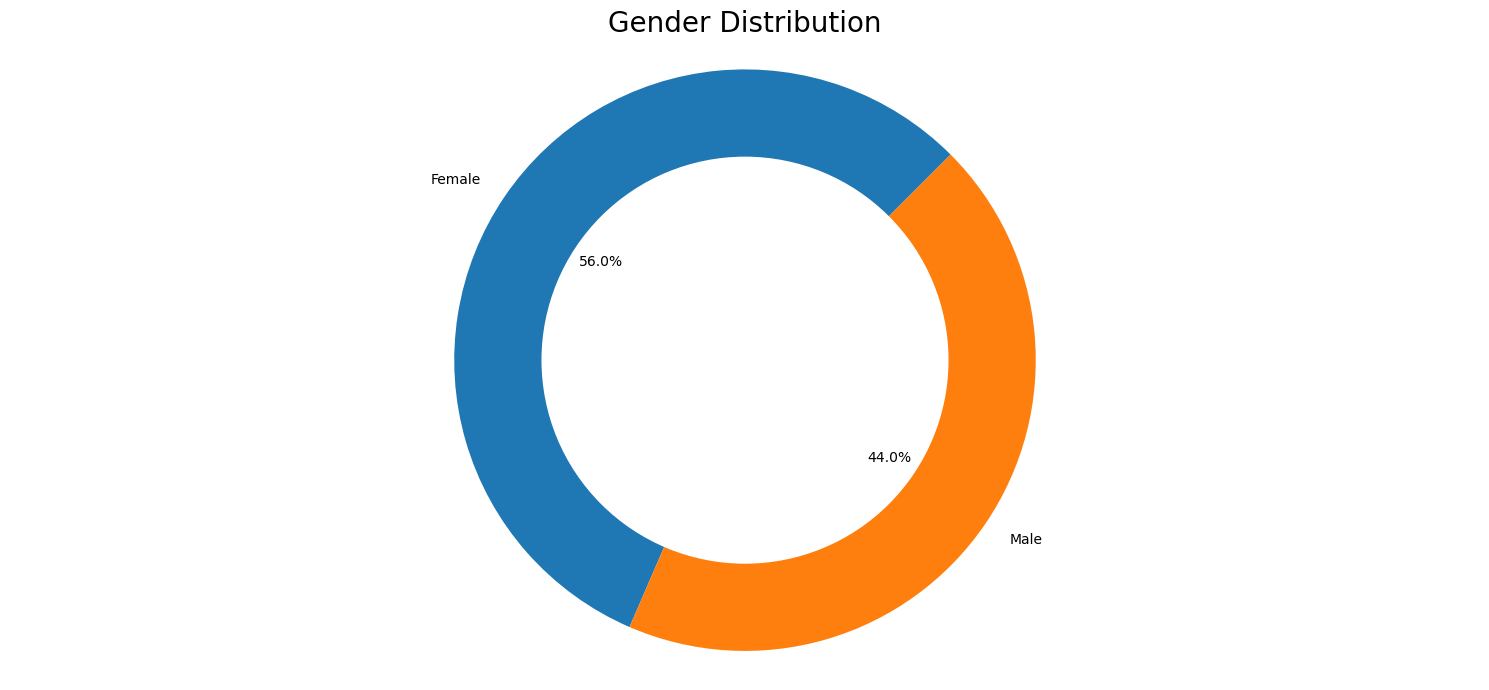

In [45]:
sizes = df['Gender'].value_counts()
labels = sizes.index

fig, ax = plt.subplots(figsize=(15, 7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45)

# Draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
ax.set_title('Gender Distribution', fontsize=20)

plt.tight_layout()
plt.show()

__Observations__
- Female customers outnumber male customers overall
- The margin of difference is not substantial enough to categorize the gender distribution as imbalanced.

# Bivariate

### Checking for Relationship between features

Why do we check for Linear relationships between variables?
- Highly correlated or redundant variables can introduce noise or unnecessary duplication of information in the dataset. Redundant features can negatively impact unsupervised learning algorithms
- Unsupervised learning algorithms often assume that variables are independent or weakly correlated,if variables are strongly correlated or dependent on each other, it can lead to biased or distorted cluster assignments. 

<AxesSubplot: >

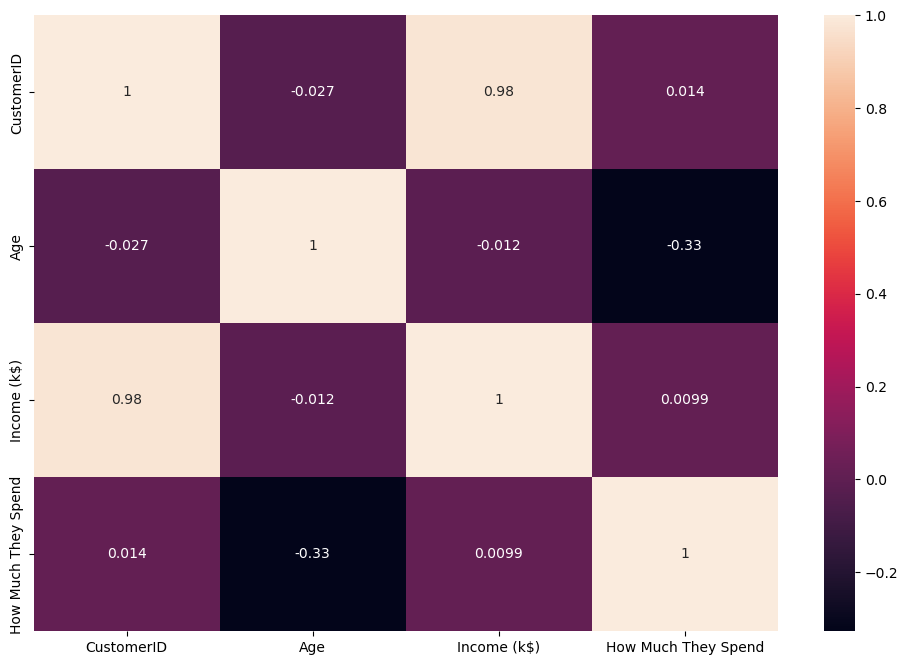

In [46]:
filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True,ax=ax)

__Observations__
- `Age` and` Customer Expenditure` have a negative weak linear relationship between them
- The rest of the features are weakly correlated with each other, which is a good sign

## To what extent does gender impact the distribution of the data?
Why do we need to focus so much on the Gender Feature? We expect that the 2 different genders would have different spending habits such as females spend more overall money shopping than males and thus have an impact in choosing the group of customers that are most valuable to the shopping mall. 

However there are a few problems we encounter if we want to keep Gender
- As __Gender is a categorical variable__. we must encode them into binary variables(1,0) this causes certain techniques such as KMeans with Euclidean distances to not be appropriate.This is because the Euclidean distance between categories like "Males" and "Females" does not have a meaningful interpretation. Additionally, the resulting cluster center coordinates for the gender variable would not make sense either. A solution to this is to use is K-Prototypes, which is specifically designed to handle mixed data types, including categorical and numerical variables, in clustering analysis.
- Another issue is the __lack of Interpretability__, as we already have 3 other features(Age,Income (k$),How Much They Spend) excluding CustomerID, and thus it would be impossible to visualize the clustering in 4 Dimensions. It would be better to drop another feature if we want to properly visualize it.

### How does the distribution of the data affect our models?
There are many factors in the distribution of the data that can affect our clustering models, such as the skewenss of the data, outliers in the dataset and imbalanced data. This can significantly affect our clustering models.

__Outliers__ 
- K-means is highly sensitive to outliers because it aims to minimize the sum of squared distances between data points and cluster centroids. Outliers, being far away from other data points, can significantly influence the position of cluster centroids, leading to suboptimal cluster formations.
- The presence of outliers can distort the shape and boundaries of clusters, making them less representative of the underlying data distribution.
- Outliers can impact the determination of the optimal number of clusters in K-means

__Skewness of dataset__
- Clustering algorithm may struggle to identify well-separated clusters due to the presence of extreme values in the long tail. As a result, the clusters may be biased towards the majority of data points, leading to uneven or unclear separation between groups.
- Skewed data can result in imbalanced cluster sizes
- Skewed data can distort the distance metrics used by clustering algorithms to measure the similarity between data points.

#### References
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9324173/
- https://www.sciencedirect.com/science/article/pii/S0047259X21001317/

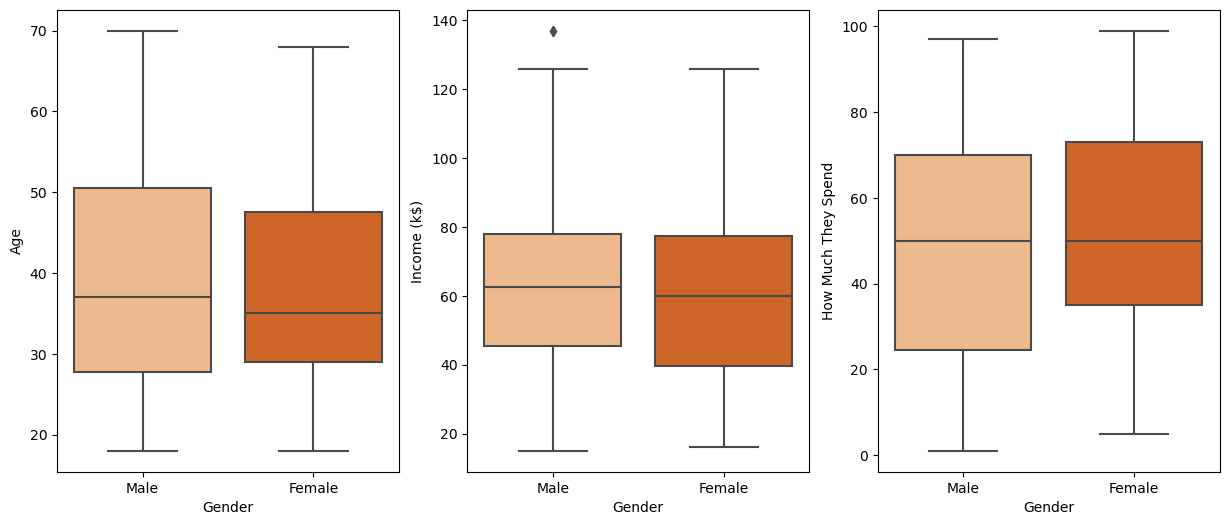

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for ax, col in zip(axes, df.drop(['Gender', 'CustomerID'], axis=1).columns):
    sns.boxplot(data=df, y=col, x='Gender', ax = ax, palette="Oranges")
fig.show()

When looking at the boxplots, it appears there is no significant difference between the distributions of males and females

#### 2 Sample T-Test
A 2 Sample T-Test helps assess whether the observed difference in sample means is likely due to a real difference in the populations from which the samples were taken or if it could have occurred by chance.

In [48]:
import scipy.stats as stats
#when gender does not significantly affect the amount spent (is good as we can drop it without affecting the model)

def t_statistic(df, categorical_vars):
    for var in categorical_vars:
        group1 = df[df['Gender'] == 'Male'][var]
        group2 = df[df['Gender'] == 'Female'][var]
        t_statistic, p_value = stats.ttest_ind(group1, group2)
    
        print("Variable:", var)
        print('H0 : Population means are equal')
        print('H1 : Population means are not equal')
        print('P-value: {:.3f}'.format(p_value))
        if p_value < 0.05:
            print("Reject Null Hypothesis as p-value < 0.05")
        else:
            print("Accept Null Hypothesis as p-value > 0.05")
        print()

t_statistic(df, ['Age', 'Income (k$)', 'How Much They Spend'])

Variable: Age
H0 : Population means are equal
H1 : Population means are not equal
P-value: 0.392
Accept Null Hypothesis as p-value > 0.05

Variable: Income (k$)
H0 : Population means are equal
H1 : Population means are not equal
P-value: 0.428
Accept Null Hypothesis as p-value > 0.05

Variable: How Much They Spend
H0 : Population means are equal
H1 : Population means are not equal
P-value: 0.414
Accept Null Hypothesis as p-value > 0.05



__Observations__
- We can see through the T-Test that Gender does not significantly affect the distribution of data

### Pairplot
- Can we see any identifiable cluster from a glance?
- Does Gender affect any of the features?

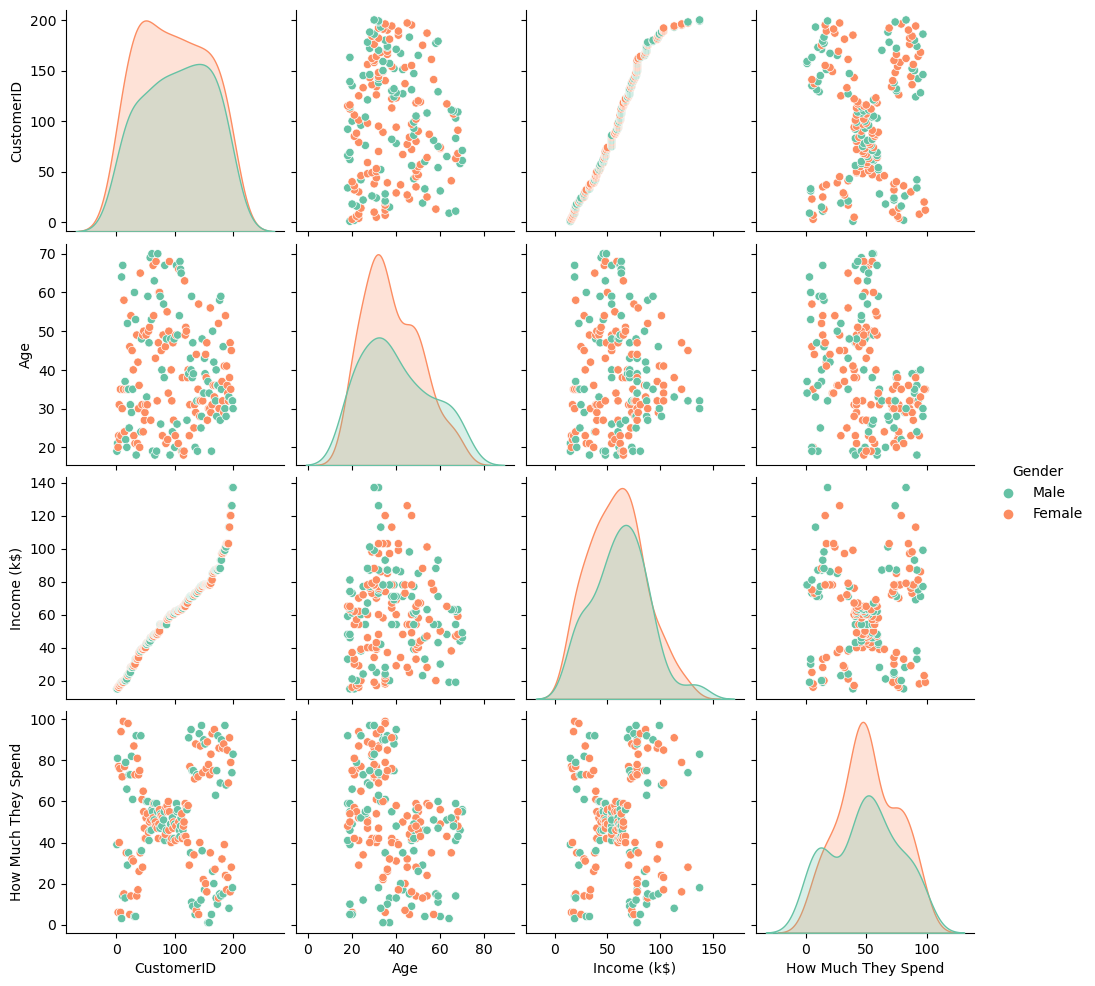

In [49]:
sns.pairplot(df, hue='Gender', palette='Set2')

__Observations__
- We can see that there are visible clustering in the scatterplot of `Customer expenditure` and `Income`
- `Gender` does not have any noticable effect on the various features
Thus we can conclude that `Gender` does not have a major impact on the distribution of the data, and we are incentivised to drop it in feature selection/engineering 

# Data Preprocessing

## Data Selection
I will be dropping the features Gender and CustomerID due to the evidence provided from the graphs and tests above

In [50]:
df_selection = df.copy()
df_selection.drop(columns=['Gender','CustomerID'], inplace=True)
df_selection

,Age,Income (k$),How Much They Spend
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


## Scaling
As our Age feature is on a different scale from Income and Customer expenditure, we need to standardize it. Using Z-Score Standardization to perform feature scaling. This is to ensure that all of the features would have the mean and variance, following N(0, 1).

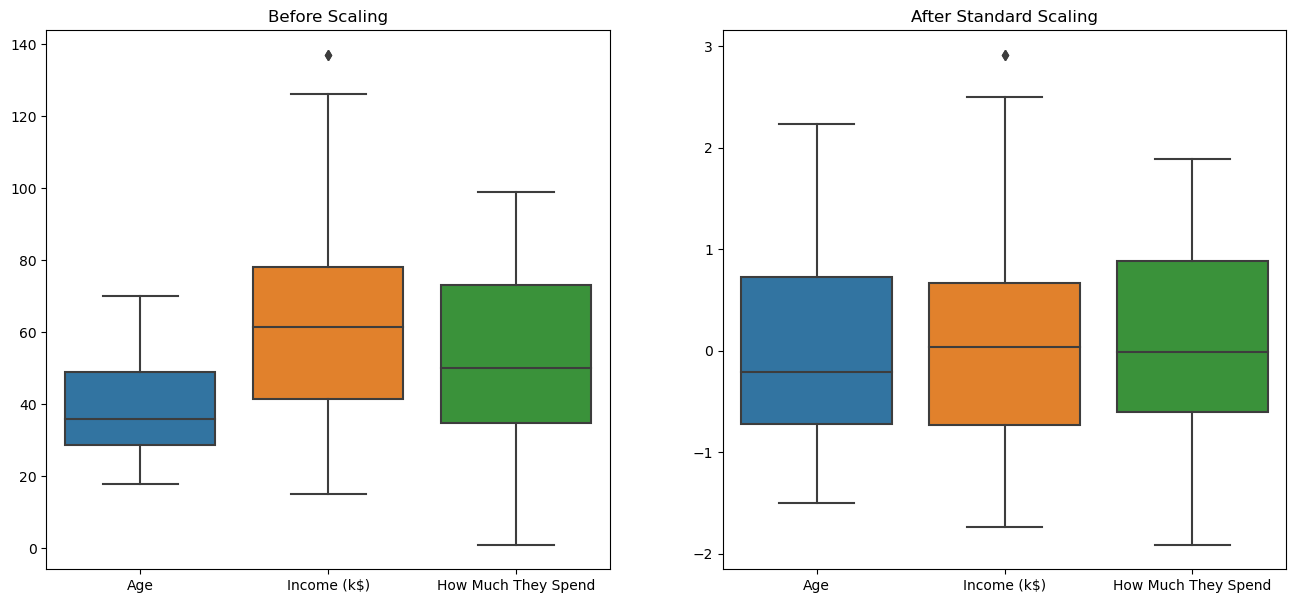

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selection)
df_scaled = pd.DataFrame(df_scaled, columns=df_selection.columns)

figure, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.boxplot(data=df_selection, ax=ax[0])
ax[0].set_title('Before Scaling')
sns.boxplot(data=df_scaled, ax=ax[1])
ax[1].set_title('After Standard Scaling')
plt.show()

# Clustering

## Functions

In [52]:

def plot_3d_clusters(df_scaled, labels, title, cluster_centers=None):
    data_points = go.Scatter3d(
        x=df_scaled['Age'],
        y=df_scaled['Income (k$)'],
        z=df_scaled['How Much They Spend'],
        mode='markers',
        marker=dict(
            size=5,
            color=labels,
            colorscale='Viridis',
            opacity=0.8
        ),
        name='Data Points'
    )

    traces = [data_points]

    if cluster_centers is not None:
        center_points = go.Scatter3d(
            x=cluster_centers[:, 0],
            y=cluster_centers[:, 1],
            z=cluster_centers[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color='red',
                symbol='x'
            ),
            name='Cluster Centers'
        )
        traces.append(center_points)

    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='Age'),
            yaxis=dict(title='Income (k$)'),
            zaxis=dict(title='How Much They Spend')
        ),
        title=str(title)
    )

    if traces:
        fig = go.Figure(data=traces, layout=layout)
        fig.show()



## Hopkins Statistics
Hopkins Statistics is a measure used to assess the clustering tendency of a dataset. It quantifies the degree to which the data points are clustered or dispersed in the feature space. The idea behind Hopkins Statistics is to compare the distribution of distances between randomly generated points and the original data points.

$$H = \frac{\sum{^{m}_{i=1}}u{^{d}_{i}}}{\sum{^{m}_{i=1}}u{^{d}_{i}} + \sum{^{m}_{i=1}}w{^{d}_{i}}}$$

- If the value is `< 0.5`, the data is regularly spaced.
- If the value is `around 0.5`, it is random.
- If the value is `> 0.5`, it has a high tendency to cluster.



In [53]:
def hopkins(X, num_iterations):
    num_features = X.shape[1]  # Number of features (columns)
    num_samples = len(X)  # Number of samples (rows)
    num_random_samples = int(0.1 * num_samples)  # Number of random samples

    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
    
    hopkins_values = []
    for _ in range(num_iterations):
        random_indices = sample(range(0, num_samples, 1), num_random_samples)

        uniformly_random_points = []
        randomly_selected_points = []
        for j in range(num_random_samples):
            # Calculate nearest neighbor distances for uniformly random points
            u_dist, _ = nbrs.kneighbors(np.random.uniform(np.amin(X, axis=0), np.amax(X, axis=0), num_features).reshape(1, -1), 2, return_distance=True)
            uniformly_random_points.append(u_dist[0][1])

            # Calculate nearest neighbor distances for randomly selected points from the dataset
            w_dist, _ = nbrs.kneighbors(X.iloc[random_indices[j]].values.reshape(1, -1), 2, return_distance=True)
            randomly_selected_points.append(w_dist[0][1])

        H = sum(uniformly_random_points) / (sum(uniformly_random_points) + sum(randomly_selected_points))
        if np.isnan(H):
            print("Error: Invalid Hopkins Statistics calculation")
            H = 0

        hopkins_values.append(H)
    
    mean_hopkins = np.mean(hopkins_values)
    return mean_hopkins

In [54]:
mean_hopkins = hopkins(df_scaled, num_iterations=5)
print("Mean Hopkins Statistics of 5 iterations:", mean_hopkins)

Mean Hopkins Statistics of 5 iterations: 0.7416950857622653


Observations
- The result of Hopkins Statistics is >0,5 , which means that our dataset has a high tendency to cluster

## K-Means Clustering

### Finding the best possible value of K
- `Elbow Method`
- `Silhouette Analysis`
- Gap Statistic

We will be using the Elbow method and Silhouette Analysis to find the best value of K

### Elbow Method (Inertia)
To find the best number of clusters for K-means, we look for the "elbow" point on the plot, which is the point where the inertia (within-cluster sum of squares) starts decreasing in a more linear and less steep manner. This point represents a balance between minimizing the inertia and avoiding overfitting. 

$$ 
\text{Inertia} = \sum^m_{i=1}||x^{(i)}-\mu_{c^{(i)}}||^2_2 
$$

Where:
- $m$ is the total number of data points
- $x_i$ represents a data point
- $μ_j$ represents the centroid of the cluster $C$ to which the data point $x_i$ belongs
- $||x_i - μ_j||$ denotes the Euclidean distance between the data point $x_i$ and the centroid $μ_j$ 


### Silhouette Analysis
Silhouette analysis is a technique used to evaluate the quality and appropriateness of clustering results. It provides a quantitative measure of how well each data point fits into its assigned cluster. 

$$
s(o) = \frac{b(o) - a(o)}{max{a(o),b(o)}}
$$

The silhouette score ranges from -1 to 1, where a `higher value` indicates that the data point is well-matched to its own cluster and poorly-matched to neighboring clusters. A score `close to 1` suggests a clear separation between clusters, while a score `close to 0` indicates overlapping or ambiguous clusters.` Negative scores` indicate that data points might have been assigned to incorrect clusters.


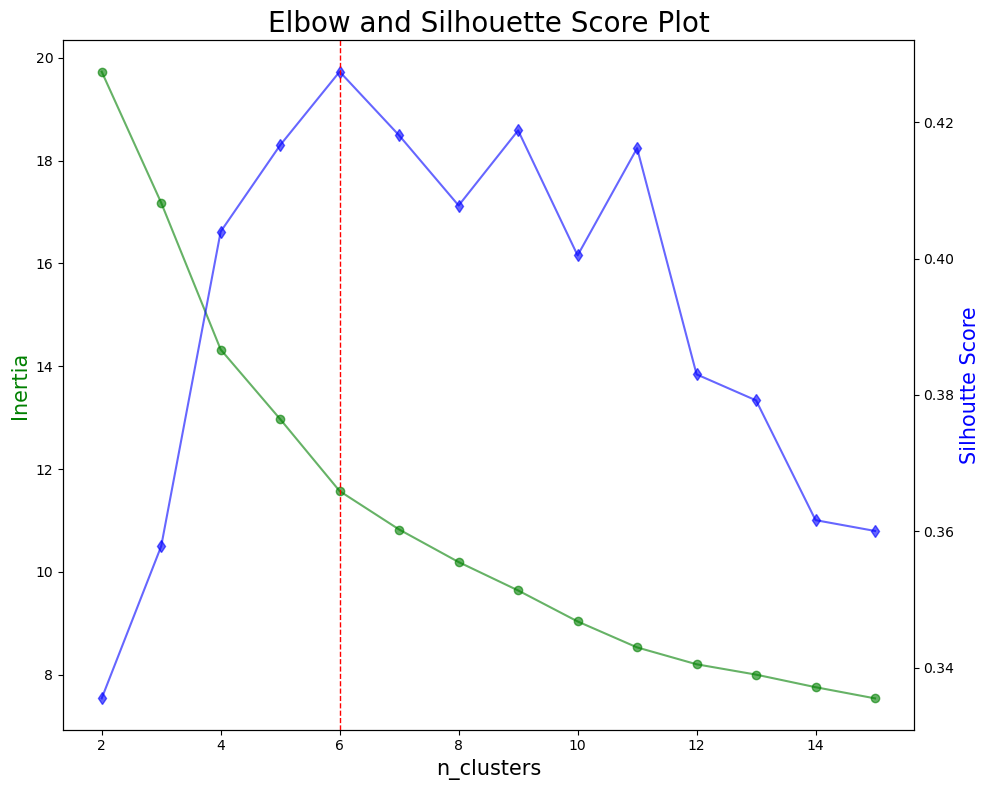

In [55]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k_values = range(2, 16)

wcss = []
s_score = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_scaled)
    label = kmeans.predict(df_scaled)
    wcss.append(np.sqrt(kmeans.inertia_))
    s_score.append(silhouette_score(df_scaled, label))

fig, axes = plt.subplots(figsize=(10,  8))

axes2 = axes.twinx()
axes.plot(k_values, wcss, 'o-', color='g', alpha=.6, label='Inertia')
axes2.plot(k_values, s_score, 'd-', color='b', alpha=.6)

axes.set_xlabel('n_clusters', fontsize=15)
axes.set_ylabel('Inertia', color='g', fontsize=15)
axes2.set_ylabel('Silhoutte Score', color='b', fontsize=15)
axes2.axvline(x=6, color='red', linestyle='--', linewidth=1)

plt.title('Elbow and Silhouette Score Plot', fontsize=20)
plt.tight_layout()
plt.show()

__Observations__
- The 'Elbow' in the plot is at k = 6 where after k = 6 the line starts to plato 
- The Silhouette score at k = 6 has the highest value showing that the data points are well-matched to its own cluster

Thus `k = 6` is the best possible value for Kmeans Clustering

## T-SNE 
t-SNE __(t-Distributed Stochastic Neighbor Embedding)__ is a dimensionality reduction technique commonly used for visualizing high-dimensional data in lower-dimensional spaces.

There are 2 main parameters to tune for t-SNE:
- Perplexity
- Learning_rate

According to the documentation of [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), Perplexity should be selected from values ranging from `5 - 50`

We will be setting the Learning rate to `'auto'` as it will allow the algorithm to adaptively determine an appropriate learning rate based on our dataset

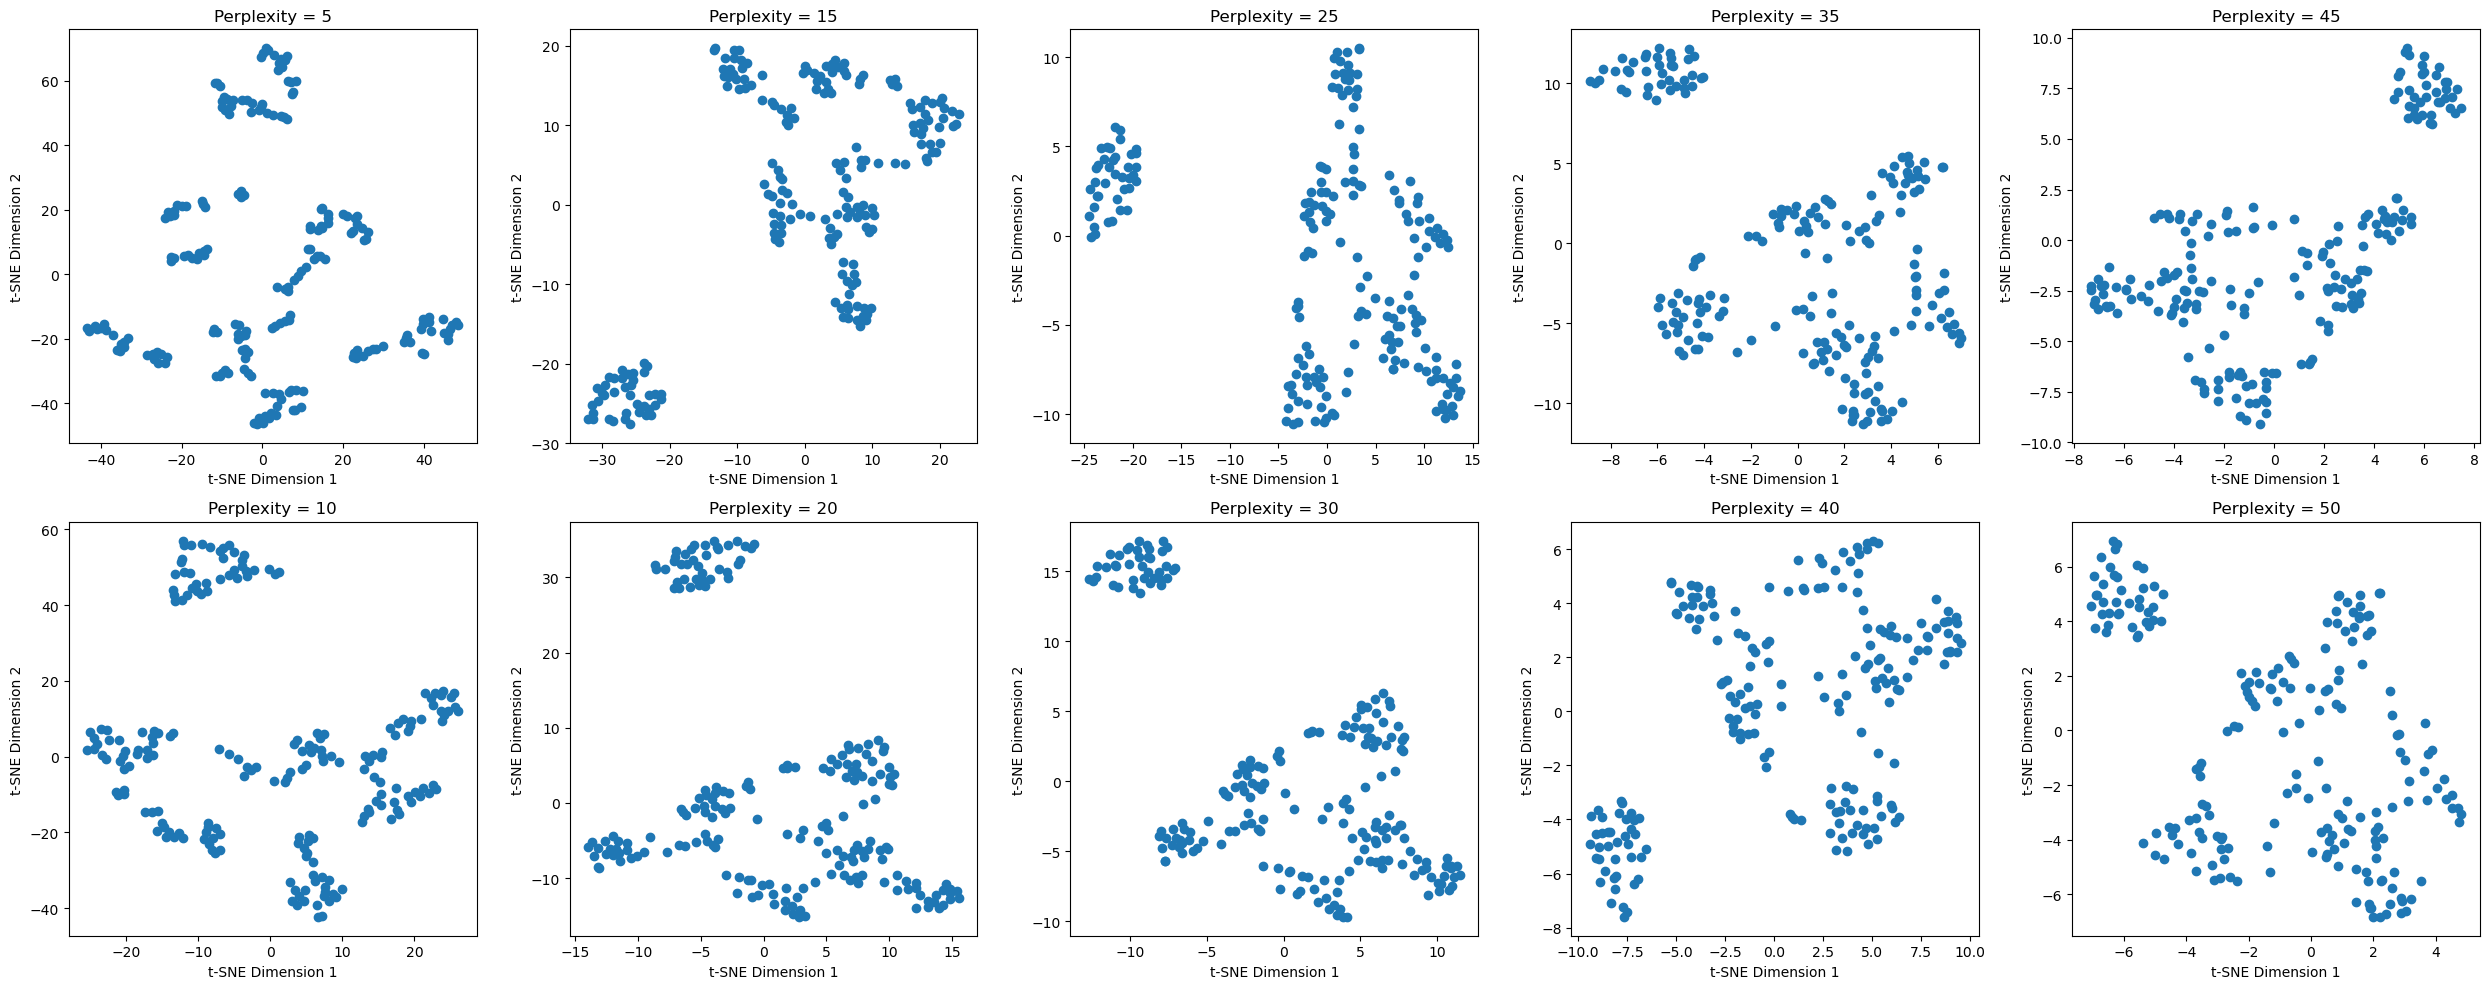

In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

perplexity_values = range(5, 51, 5)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, perplexity in enumerate(perplexity_values):
    col = i // 2
    row = i % 2
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_data = tsne.fit_transform(df_scaled)
    axes[row, col].scatter(tsne_data[:, 0], tsne_data[:, 1])
    axes[row, col].set_title(f"Perplexity = {perplexity}")
    axes[row, col].set_xlabel('t-SNE Dimension 1')
    axes[row, col].set_ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

__Observations__
- We can see that Perplexity = 25 has the best interpretability, with Perplexity = 30 coming quite close

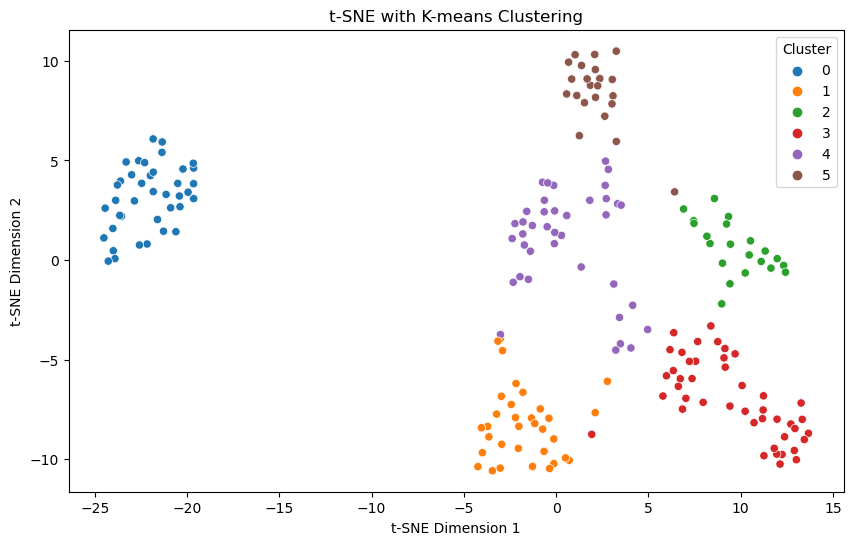

In [57]:
from sklearn.manifold import TSNE
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_scaled)
labels = kmeans.labels_

tsne = TSNE(n_components=2, random_state=42,perplexity=25,learning_rate='auto')
tsne_data = tsne.fit_transform(df_scaled)

tsne_df = pd.DataFrame({'tsne_dim1': tsne_data[:, 0], 'tsne_dim2': tsne_data[:, 1], 'Cluster': labels})

fig = plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='tsne_dim1', y='tsne_dim2', hue='Cluster', palette='tab10')
plt.title('t-SNE with K-means Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

__Observations for the 2 Graphs__
- There is Distinct cluster seperation in the graphs, where is it visible that the clusters are seperate

## K-means clustering with scaling and not scaling 
Clustering models that rely on distance-based calculations, such as k-means and density-based clustering algorithms(DBSCAN), are particularly affected by the scaling of the dataset. When features have different scales or units, the magnitude of differences can dominate the distance calculations, leading to biased clustering results. We will be comapring the results of k-means with and without scaling 

K-means clustering typically uses the Euclidean distance metric to measure the dissimilarity between data points. The Euclidean distance is sensitive to variable scales. 

We will be  using evaluation metrics like the `Davies-Bouldin Index (DBI)` and the `Calinski-Harabasz Index (CHI)` to compare the quality of clustering results, considering both the compactness within clusters and the separation between clusters. 
__Where__
- A `lower DBI` value indicates better clustering, where a value close to zero represents well-separated and compact clusters. 
- A `higher CHI` value indicates better clustering, with a higher value indicating well-separated and compact clusters.

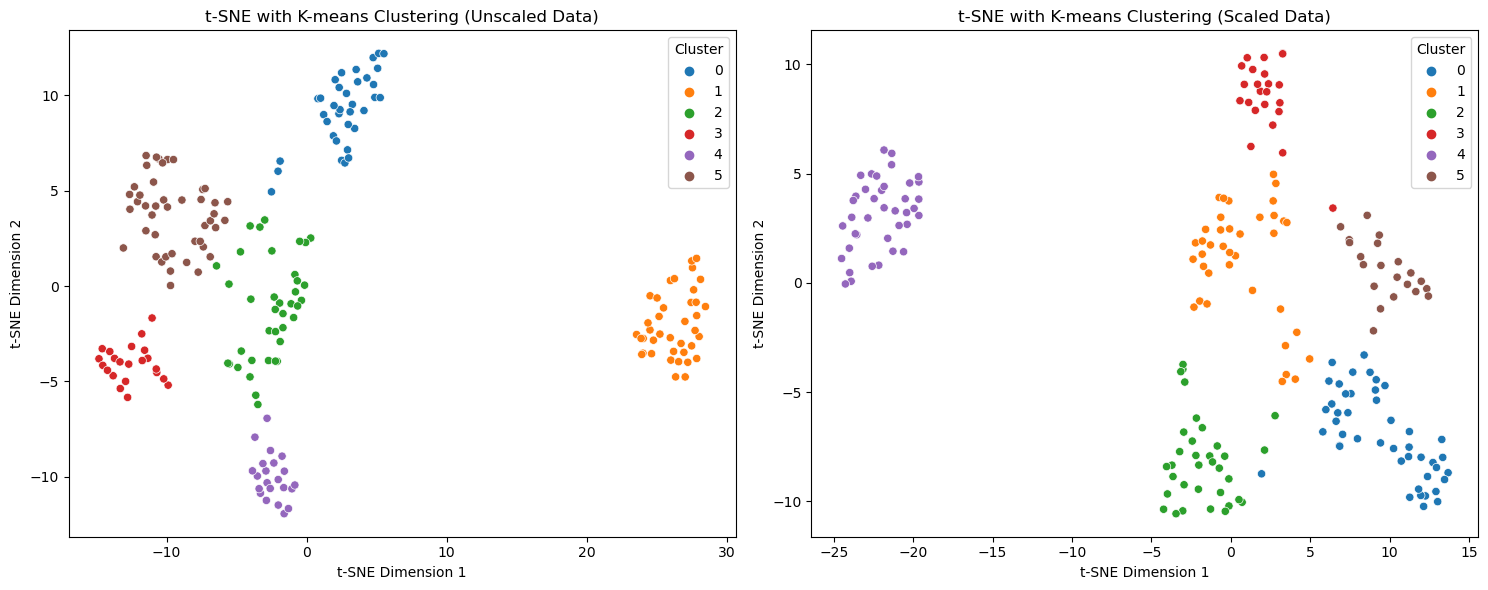

,Model,DBI Score,CHI Score
0,K-means Scaled,0.825354,135.102104
1,K-means Unscaled,0.744300,166.713573


In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

kmeans.fit(df_selection)
labels_unscaled = kmeans.labels_
# Plot with unscaled data
tsne_unscaled = TSNE(n_components=2, random_state=42, perplexity=25, learning_rate='auto')
tsne_data_unscaled = tsne_unscaled.fit_transform(df_selection)
tsne_df_unscaled = pd.DataFrame({'tsne_dim1': tsne_data_unscaled[:, 0], 'tsne_dim2': tsne_data_unscaled[:, 1], 'Cluster': labels_unscaled})

sns.scatterplot(data=tsne_df_unscaled, x='tsne_dim1', y='tsne_dim2', hue='Cluster', palette='tab10', ax=axes[0])
axes[0].set_title('t-SNE with K-means Clustering (Unscaled Data)')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_scaled)
labels_scaled = kmeans.labels_
# Plot with scaled data
tsne_scaled = TSNE(n_components=2, random_state=42, perplexity=25, learning_rate='auto')
tsne_data_scaled = tsne_scaled.fit_transform(df_scaled)
tsne_df_scaled = pd.DataFrame({'tsne_dim1': tsne_data_scaled[:, 0], 'tsne_dim2': tsne_data_scaled[:, 1], 'Cluster': labels_scaled})

sns.scatterplot(data=tsne_df_scaled, x='tsne_dim1', y='tsne_dim2', hue='Cluster', palette='tab10', ax=axes[1])
axes[1].set_title('t-SNE with K-means Clustering (Scaled Data)')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')


kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_scaled_labels = kmeans.fit_predict(df_scaled)
kmeans_unscaled_labels = kmeans.fit_predict(df_selection)

kmeans_dbi = davies_bouldin_score(df_scaled, kmeans_scaled_labels)
kmeans_chi = calinski_harabasz_score(df_scaled, kmeans_scaled_labels)

kmeansUnscaled_dbi = davies_bouldin_score(df_selection, kmeans_unscaled_labels)
kmeansUnscaled_chi = calinski_harabasz_score(df_selection, kmeans_unscaled_labels)

scores_df = pd.DataFrame({
    'Model': ['K-means Scaled', 'K-means Unscaled'],
    'DBI Score': [kmeans_dbi, kmeansUnscaled_dbi],
    'CHI Score': [kmeans_chi, kmeansUnscaled_chi]
})

plt.tight_layout()
plt.show()


display(scores_df)

__Observations__
- We can see that scaling does not really remove any biases in the dataset as we do not see any difference in  clustering, only that the data points are flipped.Indicating that the scaling did not have a substantial impact on the inherent structure of the data.
- The values of the features in the dataset were already around the same magnitude. When the feature magnitudes are comparable, scaling may not have a significant effect on the clustering results. In such cases, the inherent relationships and similarities between data points are preserved even without scaling.
- As scaling affects the shape and boundaries of the clusters. In the unscaled K-means clustering, we observe more distinct separation between the clusters, indicating a clearer distinction between different groups of data points.On the other hand, in the scaled K-means clustering, the boundaries between clusters appear to be slightly more blended, with some overlap between adjacent clusters. This suggests that scaling can influence the compactness and separation of the clusters.
- Based on the DBI and CHI scores, the unscaled K-means clustering outperformed the scaled K-means clustering in this particular dataset. The unscaled K-means clustering achieved a lower DBI score of 0.744 and a higher CHI score of 166.714 compared to the scaled K-means clustering, which had a DBI score of 0.825 and a CHI score of 135.102. These scores indicate that the unscaled K-means clustering resulted in better cluster separation and compactness.

In conclusion, while unscaled data in K-means clustering improved the separation and distinction between clusters in this particular dataset, the impact of scaling on clustering performance depends on the characteristics of the data. Scaling is particularly important when the features have different magnitudes or units, as it helps to prevent the dominance of certain variables and ensures that each feature contributes equally to the clustering process.Therefore unscaled data was more appropriate for the K-means clustering algorithm in this case.

In [59]:
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_selection)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plot_3d_clusters(df_selection, labels,'KMeans Clustering',cluster_centers)

In [60]:
df_selection

,Age,Income (k$),How Much They Spend
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


In [61]:
df_clustered = df_selection.copy()
df_clustered['Cluster'] = labels

def get_cluster_centroids(data):
    cluster_centers = data.groupby('Cluster').mean()
    cluster_centers['Cluster Size (% of Total)'] = pd.Series(data['Cluster']).value_counts() / len(data['Cluster']) * 100
    return cluster_centers



cluster_centers = get_cluster_centroids(df_clustered)
cluster_centers


,Age,Income (k$),How Much They Spend,Cluster Size (% of Total)
Cluster,,,,
0,27.000000,56.657895,49.131579,19.0
1,44.142857,25.142857,19.523810,10.5
2,41.685714,88.228571,17.285714,17.5
3,25.272727,25.727273,79.363636,11.0
4,32.692308,86.538462,82.128205,19.5
5,56.155556,53.377778,49.088889,22.5


## Hierarchical Clustering
We will be using `Divisive Hierarchical Clustering` approach to find our clusters

`Divisive hierarchical clustering` is a top-down approach in hierarchical clustering where all data points start in one cluster, and then the algorithm recursively splits the cluster into smaller clusters based on a chosen distance metric.

![How does Hierarchical Clustering work](./images/Hirarchicalclustering_explanation.png)

[Source](https://quantdare.com/hierarchical-clustering/)

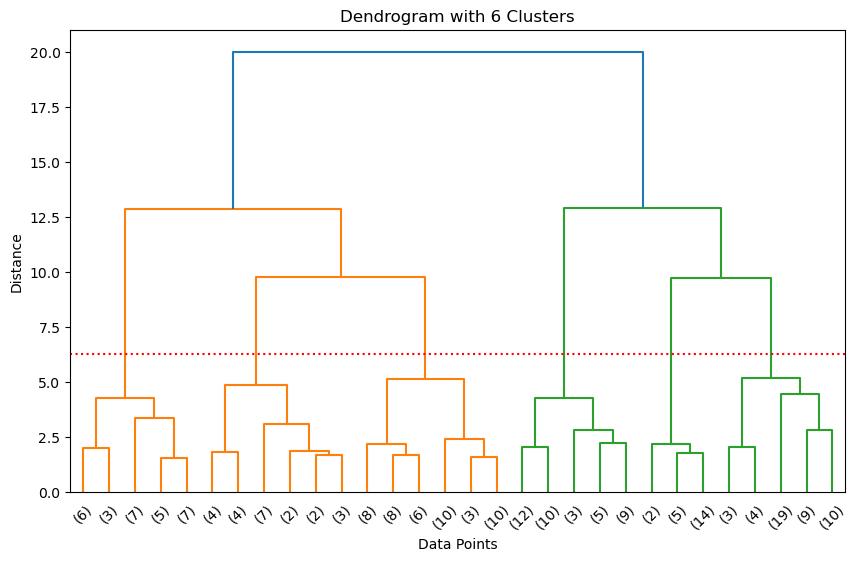

In [62]:
import numpy as np
import matplotlib.pyplot as plt
Z = linkage(df_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='lastp')
plt.axhline(y=6.25, color='red', linestyle='dotted')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Dendrogram with 6 Clusters')
plt.show()

__Observations__
- We can see that the resonable number of clusters from the dendrogram would be k = 6, as the clusters would become less defined which means that the hierarchical clustering algorithm is struggling to clearly separate the data into distinct clusters. 

In [63]:
from scipy.cluster.hierarchy import fcluster

threshold = 6.25
clusters = fcluster(Z, t=threshold, criterion='distance')

plot_3d_clusters(df_scaled, clusters, 'Hierarchical Clustering with 6 Clusters')


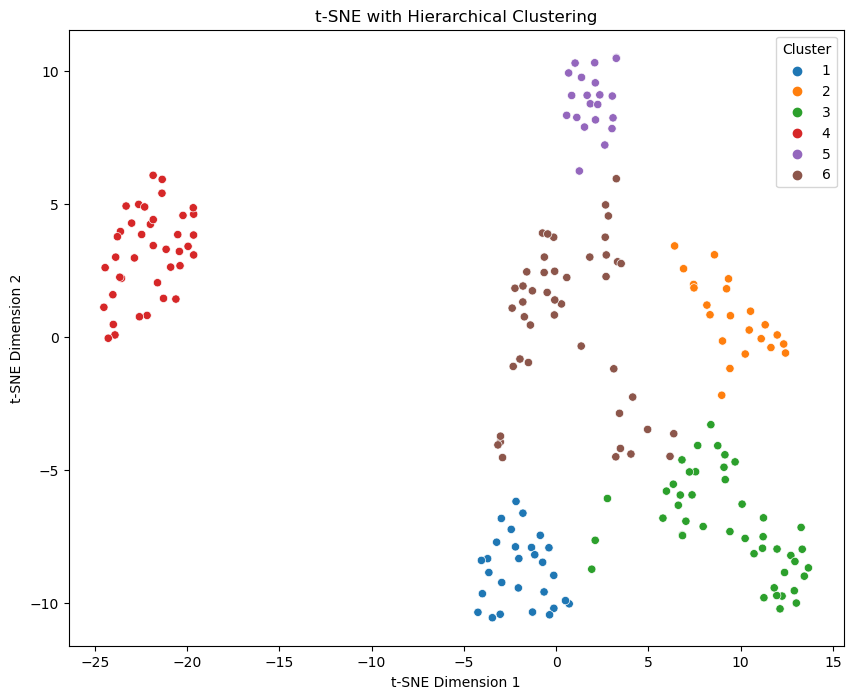

In [64]:
threshold = 6.25
clusters = fcluster(Z, t=threshold, criterion='distance')

tsne = TSNE(n_components=2, random_state=42, perplexity=25)
tsne_data = tsne.fit_transform(df_scaled)

# Create a DataFrame with t-SNE data and cluster labels
tsne_df = pd.DataFrame({'tsne_dim1': tsne_data[:, 0], 'tsne_dim2': tsne_data[:, 1], 'Cluster': clusters})

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='tsne_dim1', y='tsne_dim2', hue='Cluster', palette='tab10',ax=ax)
plt.title('t-SNE with Hierarchical Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## DBSCAN
DBSCAN is a __density based__ algorithm. It does not require specifying the number of clusters in advance. Instead, it discovers clusters based on the density of data points in the feature space.Which means we need to tune its hyperparemeters to suit our dataset.

DBSCAN has 2 parameters to tune:
- `Epsilon` (ε): It defines the radius within which neighboring points are considered part of a cluster.
- `Minimum points` (MinPts): It specifies the minimum number of neighboring points required to form a dense region.

To pick the `MinPts`, a good rule of thumb is to pick greater than or equal to the number of dimensions in the dataset [(Source)](http://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/). So we will use the range >3 to test the silhouette score to find the best MinPoint

To determine the optimal value for `epsilon`, we calculate the distance to the nearest n points for each data point, sort the distances, and create a plot. By analyzing the plot, we can identify the point where the change in distance is most significant.This pronounced change indicates a transition between different density regions. We select this point as the epsilon value, as it effectively defines the neighborhood size for clustering and captures the abrupt changes in data density.

#### How does scaling affect DBSCAN?
DBSCAN relies on a distance metric to determine the density connectivity between data points. Scaling the dataset can affect the distances between points, potentially altering the density relationships.It also uses the "epsilon" parameter to define the radius within which neighboring points are considered part of the same cluster. Scaling can affect the selection of an appropriate epsilon value. DBSCAN identifies outliers as data points that do not belong to any cluster. Scaling the dataset can impact the detection of outliers as it influences the definition of the local density.

We will be finding the Epsilon and Minpts for both Scaled and Unscaled versions of DBSCAN and conparing them at the end to see how does scaling affect DBSCAN

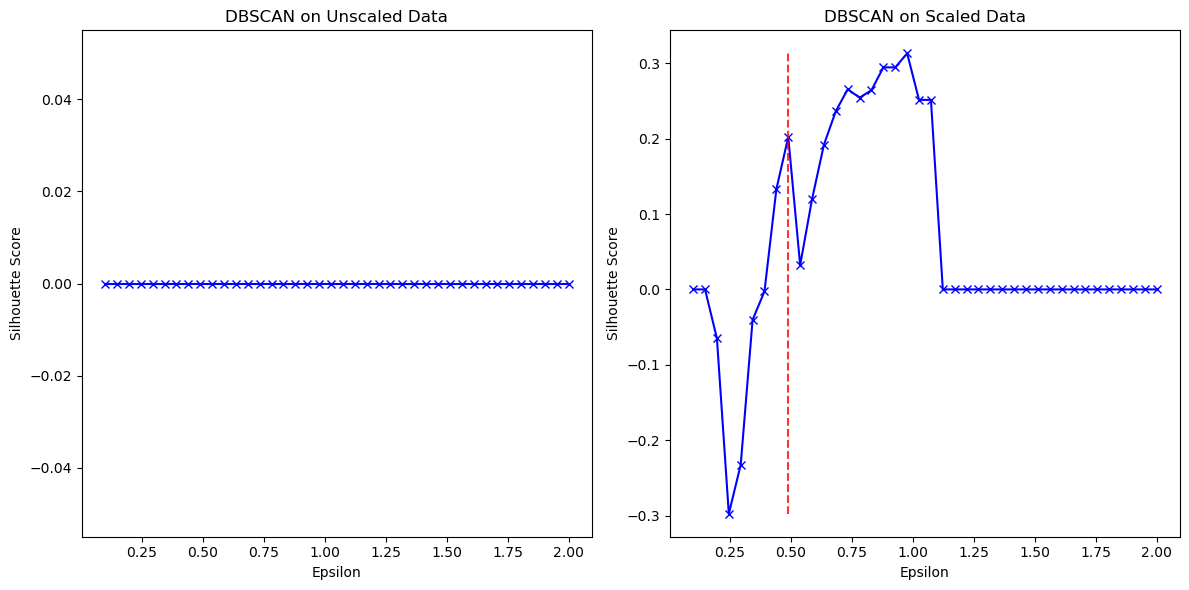

In [65]:
from sklearn.cluster import DBSCAN
epsilon_values = np.linspace(0.1, 2.0, num=40)

silhouette_scores_unscaled = np.zeros_like(epsilon_values)
silhouette_scores_scaled = np.zeros_like(epsilon_values)

for i, epsilon in enumerate(epsilon_values):
    #unscaled data
    dbscan_unscaled = DBSCAN(eps=epsilon)
    labels_unscaled = dbscan_unscaled.fit_predict(df_selection)
    if len(np.unique(labels_unscaled)) > 1:  # Skip if only one cluster is formed
        silhouette_scores_unscaled[i] = silhouette_score(df_selection, labels_unscaled)
    else:
        silhouette_scores_unscaled[i] = 0
    
    #scaled data
    dbscan_scaled = DBSCAN(eps=epsilon, min_samples=5)
    labels_scaled = dbscan_scaled.fit_predict(df_scaled)
    if len(np.unique(labels_scaled)) > 1: 
        silhouette_scores_scaled[i] = silhouette_score(df_scaled, labels_scaled)
    else:
        silhouette_scores_scaled[i] = 0

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epsilon_values, silhouette_scores_unscaled, 'bx-')
plt.vlines(x=0.489, ymin=silhouette_scores_unscaled.min(), ymax=silhouette_scores_unscaled.max(), alpha=.8, linestyles='--', color='r')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN on Unscaled Data')

plt.subplot(1, 2, 2)
plt.plot(epsilon_values, silhouette_scores_scaled, 'bx-')
plt.vlines(x=0.489, ymin=silhouette_scores_scaled.min(), ymax=silhouette_scores_scaled.max(), alpha=.8, linestyles='--', color='r')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN on Scaled Data')

plt.tight_layout()
plt.show()

__Observations__
- The Silhouette score for unscaled data is constantly 0, which means DBSCAN predicted only 1 cluster. This can be due to many issues which will be explained later
- Epsilon = 0.4897 is where the change in distance is the most pronounced for the scaled data graph, so we will use ε = 0.4897 to calculate the clusters

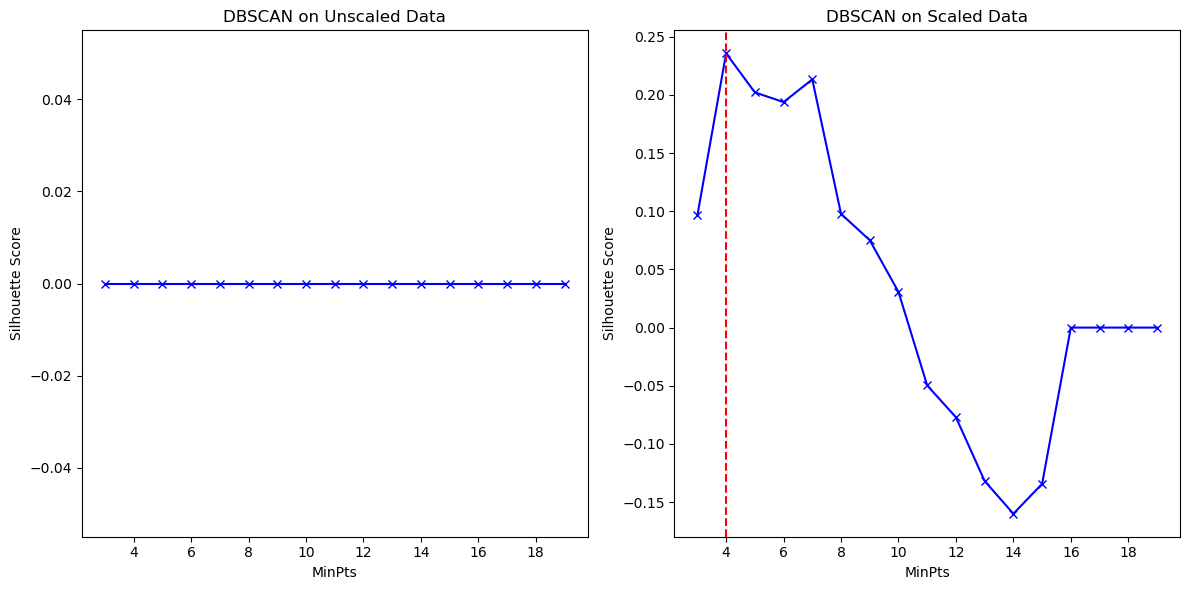

In [66]:
min_points = range(3, 20)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# DBSCAN on unscaled data
silhouette_scores_unscaled = []
for min_pts in min_points:
    dbscan_unscaled = DBSCAN(eps=0.4897, min_samples=min_pts)
    labels_unscaled = dbscan_unscaled.fit_predict(df_selection)
    if len(np.unique(labels_unscaled)) > 1:
        silhouette_scores_unscaled.append(silhouette_score(df_selection, labels_unscaled))
    else:
        silhouette_scores_unscaled.append(0)
axes[0].plot(min_points, silhouette_scores_unscaled, 'bx-')
axes[0].set_xlabel('MinPts')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('DBSCAN on Unscaled Data')

# DBSCAN on scaled data
silhouette_scores_scaled = []
for min_pts in min_points:
    dbscan_scaled = DBSCAN(eps=0.4897, min_samples=min_pts)
    labels_scaled = dbscan_scaled.fit_predict(df_scaled)
    if len(np.unique(labels_scaled)) > 1:
        silhouette_scores_scaled.append(silhouette_score(df_scaled, labels_scaled))
    else:
        silhouette_scores_scaled.append(0)
axes[1].plot(min_points, silhouette_scores_scaled, 'bx-')
axes[1].axvline(x=4, color='red', linestyle='--')
axes[1].set_xlabel('MinPts')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('DBSCAN on Scaled Data')

plt.tight_layout()
plt.show()

__Observations__
- We observe the same situation happening here, the silhouette score remaining 0 throughout the graph which tells us DBSCAN gives us only 1 cluster
- The silhouette score for the scaled graph is highest at MinPts = 10 using ε = 1.074, which indicates the configuration of MinPts that produces the most cohesive and well-separated clusters.

We will be using the default parameters for unscaled DBSCAN as we cannot find the best parameters for unscaled data

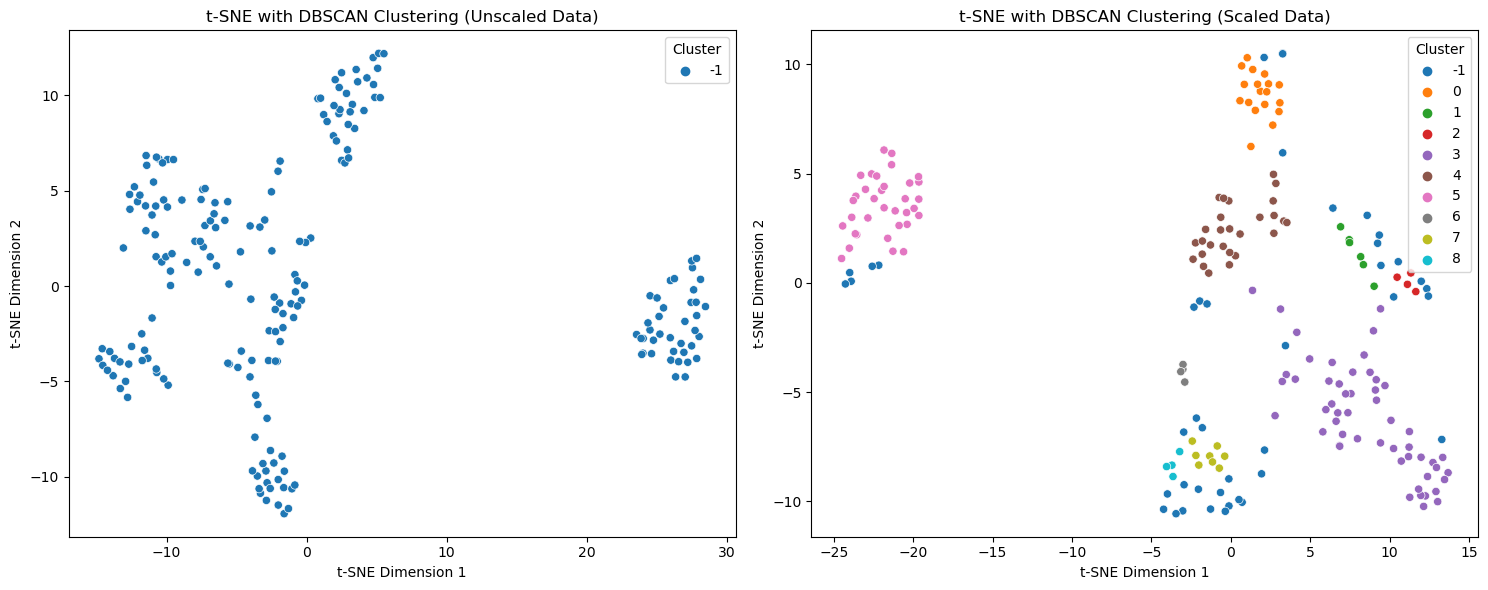

In [67]:
dbscan_unscaled = DBSCAN()
labels_unscaled = dbscan_unscaled.fit_predict(df_selection)

tsne_unscaled = TSNE(n_components=2, random_state=42, perplexity=25)
tsne_data_unscaled = tsne_unscaled.fit_transform(df_selection)
tsne_df_unscaled = pd.DataFrame({'tsne_dim1': tsne_data_unscaled[:, 0], 'tsne_dim2': tsne_data_unscaled[:, 1], 'Cluster': labels_unscaled})

dbscan_scaled = DBSCAN(eps=0.4897, min_samples=4)
labels_scaled = dbscan_scaled.fit_predict(df_scaled)

tsne_scaled = TSNE(n_components=2, random_state=42, perplexity=25)
tsne_data_scaled = tsne_scaled.fit_transform(df_scaled)
tsne_df_scaled = pd.DataFrame({'tsne_dim1': tsne_data_scaled[:, 0], 'tsne_dim2': tsne_data_scaled[:, 1], 'Cluster': labels_scaled})

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot graph
sns.scatterplot(data=tsne_df_unscaled, x='tsne_dim1', y='tsne_dim2', hue='Cluster', palette='tab10', ax=axes[0])
axes[0].set_title('t-SNE with DBSCAN Clustering (Unscaled Data)')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')

sns.scatterplot(data=tsne_df_scaled, x='tsne_dim1', y='tsne_dim2', hue='Cluster', palette='tab10', ax=axes[1])
axes[1].set_title('t-SNE with DBSCAN Clustering (Scaled Data)')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

### Why does DBSCAN give only 1 cluster?

This can be due to many reasons:
- Our unscaled dataset can have differences in the range and spread of values across the dimensions,this can affect the density calculations and the determination of neighboring points.
- As DBSCAN is sensitive to outliers, outliers in the unscaled data maybe are far away from the majority of data points and might have a larger impact on the clustering process, affecting the formation of separate clusters
- The Distribution of the dataset can also affect why DBSCAN gives only 1 cluster, as Age and Income has a positively skewed distribution. Such distribution may not be well-suited for density-based clustering

## Spectral Clustering
Spectral clustering is a machine learning algorithm used for clustering data points based on their similarity or distance.With roots in graph theory, where the approach is used to identify communities of nodes in a graph based on the edges connecting them.It can handle various types of data and is particularly effective in dealing with non-linearly separable clusters.

It is advantageous in handling non-linearly separable clusters and can capture complex structures in the data as it avoids making assumptions about cluster shapes and can accommodate different types of similarity graphs

There are a few parameters to tune:
- Affinity Matrix
- n_clusters

We will be using `n_clusters = 6`, from what we previously found from the elbow plot and silhouette plot.

In Spectral Clustering, there are two commonly used methods for constructing the affinity matrix, `Nearest Neighbors and RBF`.Additionally, there is the option to use a precomputed affinity matrix, where you can provide your own similarity matrix. But for this clustering we will only be using the 2 commonly used methods

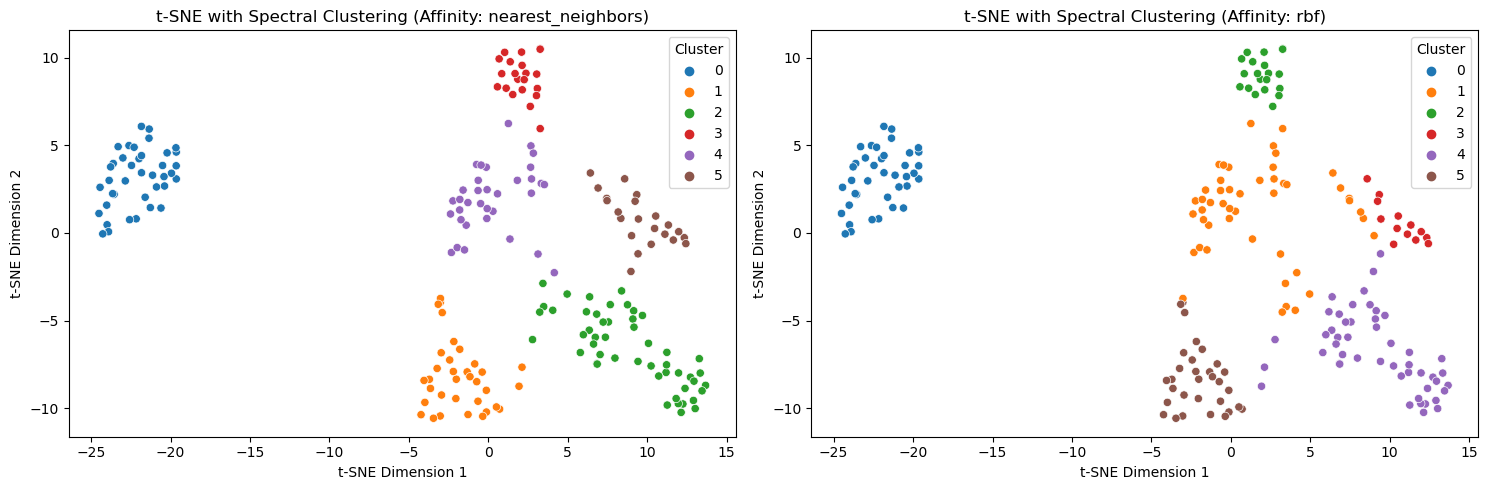

In [68]:
from sklearn.cluster import SpectralClustering

affinity_methods = ['nearest_neighbors', 'rbf']

fig, axes = plt.subplots(1, len(affinity_methods), figsize=(15, 5))

for i, affinity_method in enumerate(affinity_methods):
    spectral_clustering = SpectralClustering(n_clusters=6, affinity=str(affinity_method), random_state=42)
    labels = spectral_clustering.fit_predict(df_scaled)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=25,learning_rate='auto')
    tsne_data = tsne.fit_transform(df_scaled)
    tsne_df = pd.DataFrame({'tsne_dim1': tsne_data[:, 0], 'tsne_dim2': tsne_data[:, 1], 'Cluster': labels})
    
    ax = axes[i]
    sns.scatterplot(data=tsne_df, x='tsne_dim1', y='tsne_dim2', hue='Cluster', palette='tab10', ax=ax)
    ax.set_title(f't-SNE with Spectral Clustering (Affinity: {affinity_method})')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

Observations from spectral clustering
- The nearest_neighbors t-SNE has more distinct groups than RBF 
- cluster 1 in rbf has a wider range then cluster 4 in nearest_neighbors

# Choosen Cluster
We will be comaparing K-Means Clustering and Hierarchical Clustering on 2 scoring methods:

### Davies-Bouldin Index(DBI)
The Davies-Bouldin Index is a measure of the average similarity between clusters and the dissimilarity between clusters. It takes into account both the within-cluster scatter (variance) and the between-cluster separation.
$$
\text{DBI} = \frac{1}{N} \sum_{i=1}^{N} \max \left( \frac{s(i) + s(j)}{d(i, j)} \right)
$$
- $N$ is the number of clusters
- $s(i)$ is the average distance between each point in cluster $i$ and the centroid of cluster $i$
- $d(i, j)$ is the distance between the centroids of clusters $i$ and $j$

A `lower DBI` value indicates better clustering, where a value close to zero represents well-separated and compact clusters. 
### Calinski-Harabasz Index(CHI)
CHI measures the ratio of between-cluster dispersion to within-cluster dispersion. It seeks to maximize the inter-cluster distance while minimizing the intra-cluster distance.
$$
\text{CHI} = \frac{\text{BSS}}{\text{WSS}} \times \frac{N - k}{k - 1}
$$
- $BSS$ is the between-cluster sum of squares, representing the sum of squared distances between the cluster centroids and the overall centroid
- $WSS$ is the within-cluster sum of squares, representing the sum of squared distances between the points and their respective cluster centroids
- $N$ is the total number of data points
- $k$ is the number of clusters

A `higher CHI` value indicates better clustering, with a higher value indicating well-separated and compact clusters.

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(df_selection)

kmeans_dbi = davies_bouldin_score(df_selection, kmeans_labels)
kmeans_chi = calinski_harabasz_score(df_selection, kmeans_labels)

threshold = 6.25
hierarchical_labels = fcluster(Z, t=threshold, criterion='distance')

hierarchical_dbi = davies_bouldin_score(df_scaled, hierarchical_labels)
hierarchical_chi = calinski_harabasz_score(df_scaled, hierarchical_labels)

scores_df = pd.DataFrame({
    'Model': ['K-means', 'Hierarchical'],
    'DBI Score': [kmeans_dbi, hierarchical_dbi],
    'CHI Score': [kmeans_chi, hierarchical_chi]
})

display(scores_df)


,Model,DBI Score,CHI Score
0,K-means,0.744300,166.713573
1,Hierarchical,0.852102,127.986454


We can see that K-means has both a `lower DBI` score and `higher CHI` score than Hierarchical Clustering.Which indicates that K-means produces better clustering results in terms of both cluster separation and compactness.

A lower DBI score suggests that the clusters generated by K-means are more distinct and well-seperated, with less overlap between clusters compared to Hierarchical Clustering.

A higher CHI score suggest that the clusters are more compact and well-defined.Which implies that the between-cluster distance is large compared to the within-cluster distance, indicating clear separation between clusters.

In conclusion, K-means with its lower DBI and higher CHI score makes it more effective than Hierarchical clustering in clustering our desired amount of clusters

# Cluster Interpretation

## Visualisation

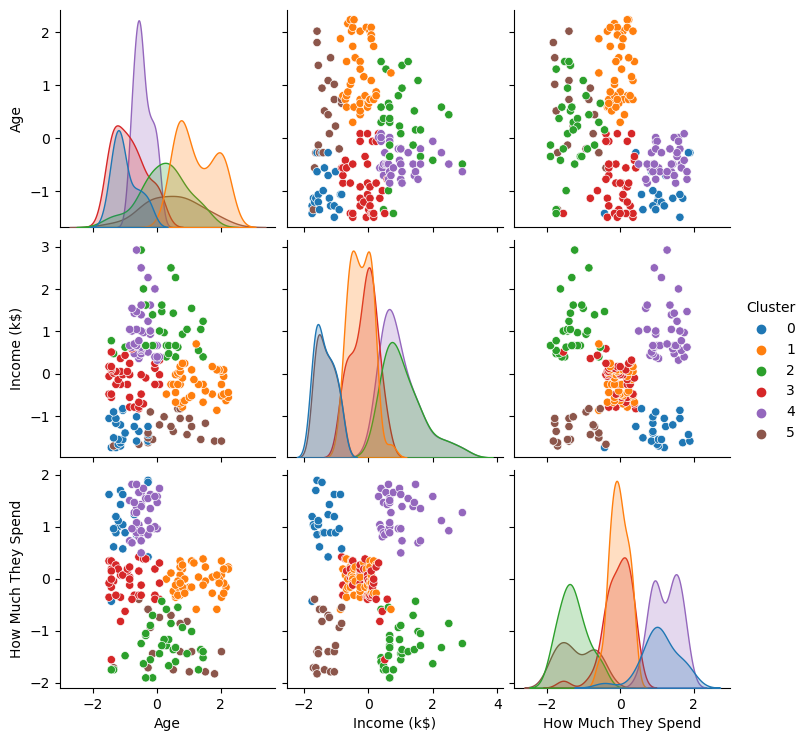

In [70]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)
kmeans_cluster_centers = kmeans.cluster_centers_

plot_3d_clusters(df_scaled, kmeans_labels,'KMeans Clustering',kmeans_cluster_centers)

df_visualization = df_scaled.copy()
df_visualization['Cluster'] = kmeans_labels

sns.pairplot(data=df_visualization, hue='Cluster', palette='tab10')

## Surrogate Model : Decision Tree
Using a Decision Tree as a surrogate model in clustering can provide valuable insights into the decision rules that determine the assignment of data points to clusters.Which can help us to better understand the decision rule by which each cluster is associated

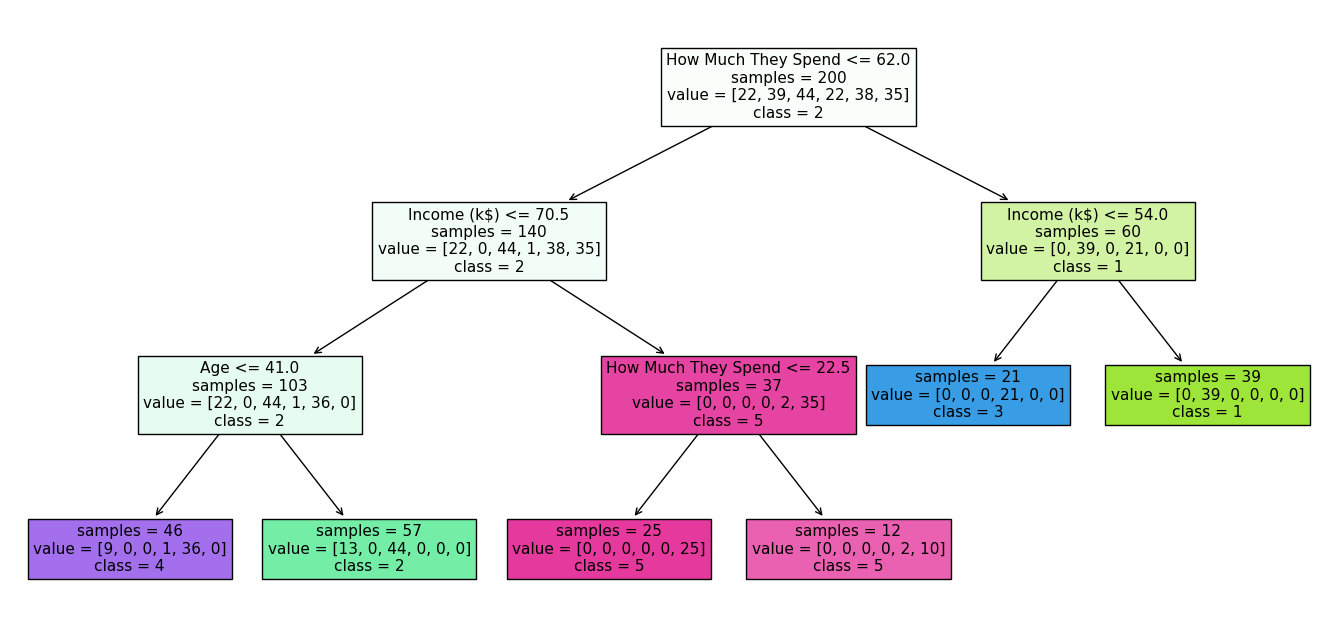

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=12)

kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(df_selection)

df_visualization = df_selection.copy()
df_visualization['Cluster'] = kmeans_labels

clf.fit(df_visualization.drop(columns='Cluster'), df_visualization['Cluster'])

fig, ax = plt.subplots(figsize = (17,8))
plot_tree(
            clf,
            feature_names = df_visualization.drop(columns='Cluster').columns,
            class_names= np.unique(df_visualization['Cluster'].values.astype(str)),
            impurity=False,
            filled = True, 
            ax = ax, 
            fontsize=11
            )
plt.show()

## Cluster Interpretation

### Cluster 0 "Teenage Overspenders"
This Cluster has a high tendency to __spend more than they earn__, with the majority of the cluster members __being youngesters__ 
> These youngester have a tendecy to spend more than they earn, most probalby getting allowance from their parents. To target this cluster, the marketing strategy can be to use `Social Media and Influencer marketing`. The shopping mall can collaborate with relevant influencers or micro-influencers who have a strong following among young consumers and provide incentives for customers to share their experiences and purchases on social media, which can thus attracted more youngesters to our mall to spend more.

### Cluster 1 "Older Spenders with stable income"
This Cluster consist mostly of people who are in the later stages of their lives, which means that they can have different prioties comapred to younger customers. Such as having a greater focus on quality, comfort and convenice. Their stable income can come from their retirement pensions, investments or established careers
> While this cluster may have a good level of financial stability, they tend to exhibit moderate spending habits and are mindful of their expenses. we can infer that customers in this cluster seek value for their money and thus would appreciate products and services that offer a good balance of quality and price. A marketing stratgey can include offering competitive pricing, promotions, and loyalty programs that can attract and retain customers from this cluster. 

### Cluster 2 "Stingy Buyers"
This Cluster suggests that these individuals are financially well-off but exhibit cautious spending behavior. These customers are the one that we need to `focus the most` on, as they have untapped spending potential due to their stinginess. 
>As they are our priotity group of customers , we can include stragies such as implementing a loyalty program that rewards customers for their repeat business. Offer incentives such as exclusive discounts, early access to sales, or bonus points that can be redeemed for future purchases. Better customer service to build trust and loyalty.Promoting cost saving initatives, such as free parking, special discounts during off-peak hours, or bulk purchase discounts.

### Cluster 3 "Working Adults"
This Cluster is similar to cluster 1 with the only difference being the age. With Cluster 3 having most of its memebers being young. They are likely to be in their 20s to early 40s, balancing work responsibilities and personal life.
>Working adults in this cluster have moderate spending habits and may tend to spend their income on a mix of essential purchases and discretionary spending. Showing that they are not overly extravagant but are willing to allocate a portion of their income towards leisure activties. Assuming that they are in their working stage of life, this cluster is likely to have busy schedules and commitments related to their jobs or careers and may value convenience and time-saving options when it comes to shopping. To cater to this, one way is by enchancing the convience of the experience in the shopping mall. We can do this by providing a seamless shopping experience with convenient amenities, such as parking facilities, easy access to stores, and digital platforms for online browsing and purchasing.

### Cluster 4 "High Flyers"
This Cluster is characterized by individuals who have achieved financial success and have a significant disposable income to support their lavish lifestyle. As middle-aged individuals, we can infer that they have accumulated wealth and are in a position to enjoy the finer things in life. 
> We can assume that this group of customers are not afraid to spend more on high-end products, luxury brands, and premium experiences.They may appreciate personalized services, unique shopping experiences, and a sophisticated atmosphere.To attract this cluster we can provide personal and exclusive experiences such as VIP lounges, concierge services, and private shopping. 

### Cluster 5 "Broke"
This Cluster belongs to individuals who have low income and low expenditure at the mall. We can see that they prioritize financial stability and are cautious in their purchasing decisions and are more focused on meeting their basic needs rather than indulging in luxury or discretionary purchases.
>This is the Cluster that needs the `most assistance` from the mall. Few ways that we can help them is to ensure that our shopping mall provides a wide range of affordable products, offer regular promotions, discounts and special deals. We can also establish partnerships with affordable brands that offer quality products at affordable prices. This can help paint the shopping mall in a better light, thus attracting more customers.



## How do we appeal to our most valuable groups of customers?

#### Our most valuable groups of customers are:
- Cluster 2 'Stingy Buyers'
    - This cluster has the most __'untapped potential'__ out of all the clusters, as they have the ability to spend more than what they are spending now.
- Cluster 0 'Teenage Overspenders'
    - The aim for this cluster is to retain them and if possible use marketing strategies to encourage them to spend more at the shopping mall
- Cluster 4 'High Flyers' 
    - This cluster focuses more on the luxury side of the mall, where they are not afraid to spend more on luxury goods and services. The aim is to also retain them and encourage them to spend more money at the mall.

### What can the Shopping mall do to retain and increase profits from this group of customers?
As our main goal is to retain and get more customers to shop at the mall, we should devise the following 2 strategies to boost the growth and reputation of the mall.

### 1. Enhancing Customer Experience
Enhancing customer experience can benefit all the clusters and we can expect to see a growth in customers if done right.This can be done by providing exceptional customer experiences across the mall, which includes creating a welcoming and comfortable environment, offering top-notch customer service and ensuring that all aspects of the shopping journey are seamless and enjoyable. THus satisfied customers are more likely to become loyal patrons and recommend the mall to others, which can lead to increased foot traffic and revenue.

### 2. Loyalty and Rewards Programs
By implementing loyalty programs that provide incentives and rewards to customers for their continued patronage. These programs can encourage repeat visits and higher spending from existing customers. By offering exclusive perks, discounts, and personalized benefits to loyal customers, the shopping mall can strengthen customer loyalty and increase customer lifetime value.

# Reflection

I found the clustering process very interesting, as i feel that clustering creates order out of disorder which is an interesting concept to me. The given example dataset serves as a great demonstration of the clustering process, eventhough it maybe idealistic. This process tought me on more of how does machine learning go hand in hand in real life situations such as customer segmentation. It highlights the potential of data science in optimizing marketing efforts, enhancing customer experience, and ultimately driving business growth for the shopping mall.

![Stonks Meme](./images/stonks.jfif)